In [281]:
import pandas as pd

In [282]:
DATA = 'ech_dataset'

In [283]:
articles = !ls echr_dataset

In [284]:
!ls echr_dataset/Article6/

cases_a6.csv		     ngrams_a6_full.csv       ngrams_a6_relevantLaw.csv
ngrams_a6_circumstances.csv  ngrams_a6_law.csv	      topics6.csv
ngrams_a6_featureNames.txt   ngrams_a6_procedure.csv  topics6_vocab.txt


In [285]:
def get_article(path, features):
    files_raw = !ls {path}
    files_features = ['cases', 'circumstances', 'featureNames', 'full', 'law', 'procedure', 'relevantLaw', 'topics', 'topicsVocab']
    files = dict(zip(files_features, files_raw))
    
    group = []
    for feature in features:
        if(feature == 'topics'): raw = pd.read_csv(path+files[feature], sep='\t', header=None)
        elif(feature == 'topicsVocab'): raw = open(path+files[feature]).read(); raw.replace('\n', '').replace(', ', ',').split(',')
        else: raw = pd.read_csv(path+files[feature], header=None)
        
        if feature == 'cases': raw = raw[1]
            
        group.append(raw)
    return pd.concat(group, axis=1, ignore_index=True)

In [286]:
!ls echr_dataset

Article3  Article6  Article8


In [287]:
data = get_article('echr_dataset/Article8/', ['cases', 'full'])

In [288]:
X = data.iloc[:, 1:]

In [289]:
y = data[0]

In [290]:
X.head()

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,0.004009,0.0,0.0,0.000000,0.001145,0.0,0.0,0.0,0.000573,0.004582,...,0.000000,0.000000,0.000000,0.0,0.000573,0.002291,0.000000,0.001145,0.0,0.0
1,0.000156,0.0,0.0,0.000156,0.000781,0.0,0.0,0.0,0.000000,0.001093,...,0.010303,0.000312,0.000312,0.0,0.000000,0.000468,0.000000,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.000354,0.000000,0.0,0.0,0.0,0.001772,0.000709,...,0.000354,0.000000,0.000354,0.0,0.000000,0.002481,0.000709,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.005333,...,0.000000,0.000000,0.000000,0.0,0.000000,0.003556,0.000000,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [370]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

import numpy as np

In [193]:
param_grid = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]

In [194]:
clf = make_pipeline(preprocessing.StandardScaler(), 
                    GridSearchCV(SVC(),
                                 param_grid=param_grid, cv=10, refit=True))

In [195]:
feature_tests = [
    ['cases', 'full'],
    ['cases', 'procedure'],
    ['cases', 'circumstances'],
    ['cases', 'relevantLaw'],
    ['cases', 'circumstances', 'relevantLaw'],
    ['cases', 'law'],
    ['cases', 'topics'],
    ['cases', 'topics', 'circumstances']
]

In [196]:
articles = !ls echr_dataset

for article in articles:
    article_mean = []
    for feature_test in feature_tests:
        data = get_article(f'echr_dataset/{article}/', feature_test)
        X = data.iloc[:, 1:]
        y = data[0]
        score = np.mean(cross_val_score(clf, X, y, cv=10))
        article_mean.append(score)
        print(f'{article} - {feature_test}: {score}')
    print(f'{article} - mean: {np.mean(article_mean)}')

Article3 - ['cases', 'full']: 0.6862179487179487
Article3 - ['cases', 'procedure']: 0.6548076923076923
Article3 - ['cases', 'circumstances']: 0.6669871794871794
Article3 - ['cases', 'relevantLaw']: 0.635576923076923
Article3 - ['cases', 'circumstances', 'relevantLaw']: 0.7240384615384616
Article3 - ['cases', 'law']: 0.5278846153846154


KeyboardInterrupt: 

In [ ]:
X = X.as_matrix()

In [ ]:
X.reshape([254, 2000])
X.shape

In [ ]:
y = np.array([1 if i == 'v' else 0  for i in y])
y = y.reshape(254, 1)
y.shape

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [394]:
X_train.shape

(177, 2000)

In [382]:
X_test.shape

(77, 2000)

In [388]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [389]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2000, 4000)
        self.fc2 = nn.Linear(4000, 1000)
        self.fc3 = nn.Linear(1000, 500)
        self.fc4 = nn.Linear(500, 100)
        self.fc5 = nn.Linear(100, 20)
        self.fc6 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc6(x))
        x = nn.Sigmoid()(x)
        
        return x

In [390]:
net = Net()
opt = optim.Adam(net.parameters(), lr=0.0003, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [396]:
def  train_epoch(model, opt, criterion, batch_size=177):
    model.train()
    losses = []
    for beg_i in range(0, len(X_train), batch_size):
        x_batch = torch.from_numpy(X_train[beg_i:beg_i + batch_size]).float()
        y_batch = torch.from_numpy(y_train[beg_i:beg_i + batch_size]).float()
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        y_hat = net(x_batch)
        loss = criterion(y_hat, y_batch)
        loss.backward()
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [397]:
import matplotlib.pyplot as plt

Epoch 0: Loss: 0.7480899691581726
Epoch 10: Loss: 0.7287647724151611
Epoch 20: Loss: 0.7079124450683594
Epoch 30: Loss: 0.6939910054206848
Epoch 40: Loss: 0.6931461691856384
Epoch 50: Loss: 0.6931986212730408
Epoch 60: Loss: 0.6931461691856384
Epoch 70: Loss: 0.6934042572975159
Epoch 80: Loss: 0.6931461691856384
Epoch 90: Loss: 0.6931461691856384


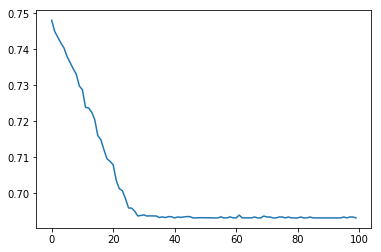

In [398]:
e_losses = []
num_epochs = 100
for e in range(num_epochs):
    loss = train_epoch(net, opt, criterion)
    e_losses += loss
    if e % 10 == 0: 
        for param_group in opt.param_groups:
            param_group['lr'] /= 1.1
        print(f'Epoch {e}: Loss: {loss[0]}')
        
plt.plot(e_losses)

In [405]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        X_test_ = torch.from_numpy(X_test).float()
        y_test_ = torch.from_numpy(y_test).float()
        output = model(X_test_)     
    
    print(X_test)

In [406]:
test(net)

[[0.         0.00043384 0.         ... 0.         0.         0.        ]
 [0.00613246 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00440529 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.02501668 ... 0.         0.         0.        ]]


In [414]:
X_test[0].reshape(2000,1)

array([[0.        ],
       [0.00043384],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [418]:
net(Variable(torch.from_numpy(X_test[0].reshape(1, 2000)).float()))

tensor([[ 0.5000]])